In [ ]:
# Install necessary packages
!pip install roboflow ultralytics albumentations


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 104.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
# Import libraries
from roboflow import Roboflow
import os
import cv2
import albumentations as A
from ultralytics import YOLO
from google.colab import files

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Download dataset from Roboflow
rf = Roboflow(api_key="tx8E4HV1RhgocqHlo8yA")
project = rf.workspace("nish-13tvc").project("sign-language-rwuyj-fdu2v")
version = project.version(1)  # Use the dataset version you want, e.g., augmented version if you created one
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Sign-Language-1 in yolov11:: 100%|██████████| 212/212 [00:00<00:00, 11468.72it/s]


In [ ]:
# Set paths for training images and labels
images_dir = os.path.join(dataset.location, "train/images")
labels_dir = os.path.join(dataset.location, "train/labels")

# Create directories for augmented images and labels
aug_images_dir = os.path.join(dataset.location, "train_aug/images")
aug_labels_dir = os.path.join(dataset.location, "train_aug/labels")
os.makedirs(aug_images_dir, exist_ok=True)
os.makedirs(aug_labels_dir, exist_ok=True)

In [ ]:
# Define augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.Blur(blur_limit=3, p=0.3)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.


In [ ]:
# Function to apply augmentation and save new images and labels
def augment_dataset():
    for img_file in os.listdir(images_dir):
        if not img_file.endswith(".jpg"):
            continue
        image_path = os.path.join(images_dir, img_file)
        label_path = os.path.join(labels_dir, img_file.replace('.jpg', '.txt'))

        # Read image and label file
        image = cv2.imread(image_path)
        with open(label_path, 'r') as f:
            bboxes = []
            class_labels = []
            for line in f.readlines():
                parts = line.strip().split()
                class_labels.append(int(parts[0]))
                bbox = list(map(float, parts[1:5]))
                bboxes.append(bbox)

        # Apply augmentation
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_class_labels = augmented['class_labels']

        # Save augmented image
        aug_img_name = "aug_" + img_file
        cv2.imwrite(os.path.join(aug_images_dir, aug_img_name), aug_image)

        # Save augmented labels
        aug_label_name = aug_img_name.replace('.jpg', '.txt')
        with open(os.path.join(aug_labels_dir, aug_label_name), 'w') as f:
            for cls, bbox in zip(aug_class_labels, aug_bboxes):
                bbox_str = ' '.join(map(str, bbox))
                f.write(f"{cls} {bbox_str}\n")

    print("Augmentation complete.")

# Run augmentation
augment_dataset()



Augmentation complete.


In [ ]:
# Adjust the dataset YAML file to point to augmented folders
data_yaml_path = os.path.join(dataset.location, "data.yaml")
with open(data_yaml_path, 'r') as f:
    data_yaml = f.read()

data_yaml = data_yaml.replace("train: train/images", "train: train_aug/images")
data_yaml = data_yaml.replace("val: valid/images", "val: valid/images")  # Keep valid same or adjust if needed

with open(data_yaml_path, 'w') as f:
    f.write(data_yaml)

print("Updated data.yaml to use augmented train dataset.")

Updated data.yaml to use augmented train dataset.


In [ ]:
# Train YOLOv11 model on augmented dataset
from ultralytics import YOLO

model = YOLO('yolo11n.pt')  # Add .pt to use pretrained weights, will download if not present
  # Use a light YOLOv11 model suitable for fast training
results = model.train(data=data_yaml_path, epochs=100, imgsz=640)

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Sign-Language-1/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True


image 1/1 /content/Sign-Language-1/test/images/family8_jpeg.rf.ae65afa8b61a24f36b2cfefb1df76bef.jpg: 384x640 1 Family, 263.7ms
Speed: 11.3ms preprocess, 263.7ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)


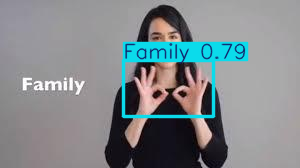

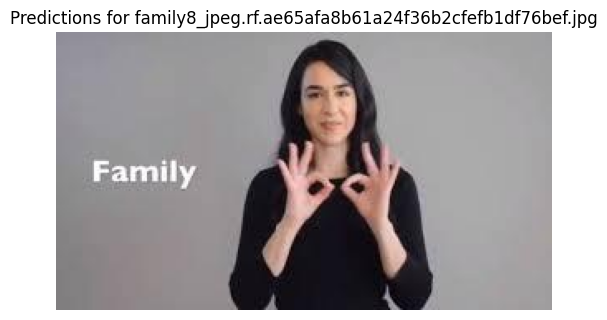


image 1/1 /content/Sign-Language-1/test/images/yes4_jpeg.rf.f720f4a3a4073f85487b01d963469287.jpg: 384x640 (no detections), 52.7ms
Speed: 6.3ms preprocess, 52.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


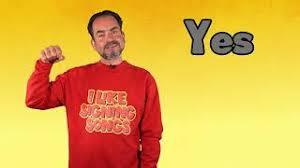

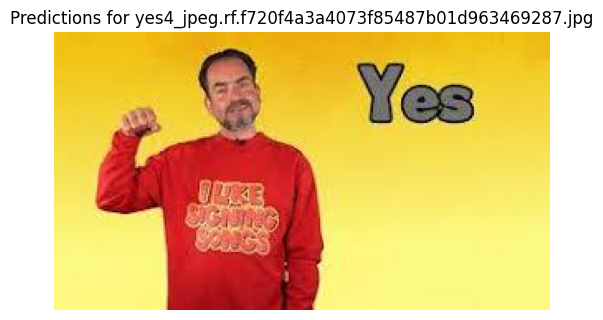


image 1/1 /content/Sign-Language-1/test/images/help8_jpeg.rf.e6860e77c49e4696153ddce921be00d4.jpg: 384x640 1 Help, 49.6ms
Speed: 7.2ms preprocess, 49.6ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


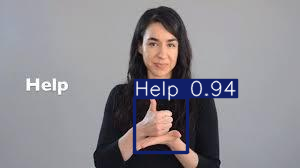

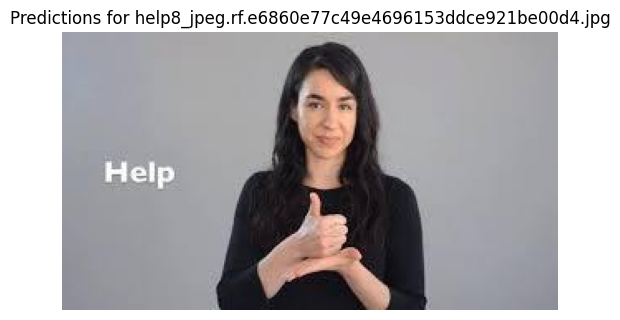


image 1/1 /content/Sign-Language-1/test/images/ily5_jpeg.rf.32c88eb1db6e2864577ec071d4de69a0.jpg: 480x640 1 Hello, 1 I Love You, 174.9ms
Speed: 8.7ms preprocess, 174.9ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)


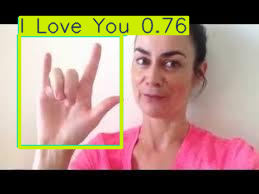

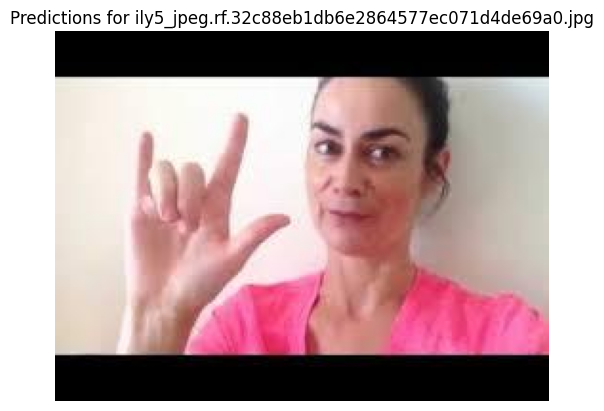


image 1/1 /content/Sign-Language-1/test/images/hello8_png.rf.a61dea764b24c98d8a3e5779f8ad85d1.jpg: 640x544 1 Hello, 215.0ms
Speed: 20.9ms preprocess, 215.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


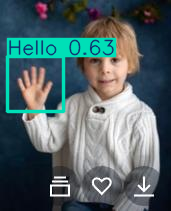

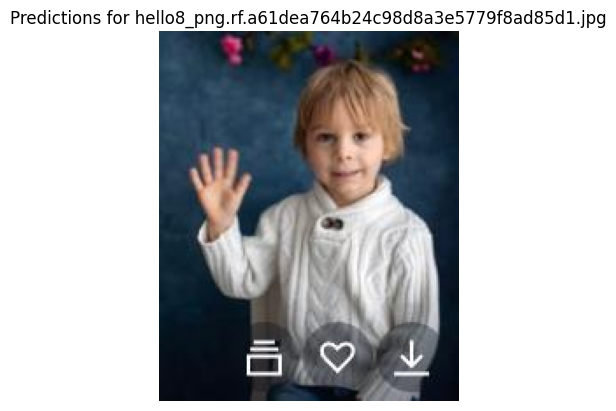


image 1/1 /content/Sign-Language-1/test/images/house7_jpeg.rf.e54cf2b0cb9bf3579ea69fdb18d173df.jpg: 480x640 (no detections), 35.3ms
Speed: 2.6ms preprocess, 35.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


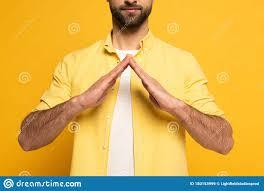

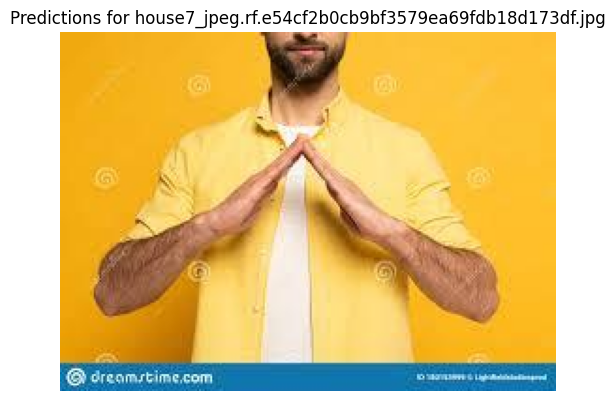


image 1/1 /content/Sign-Language-1/test/images/please3_jpeg.rf.cc65c259b6bf33318133f0ca19e378af.jpg: 384x640 1 Please, 27.3ms
Speed: 3.1ms preprocess, 27.3ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)


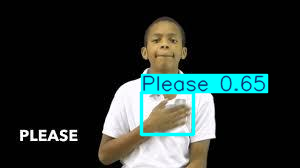

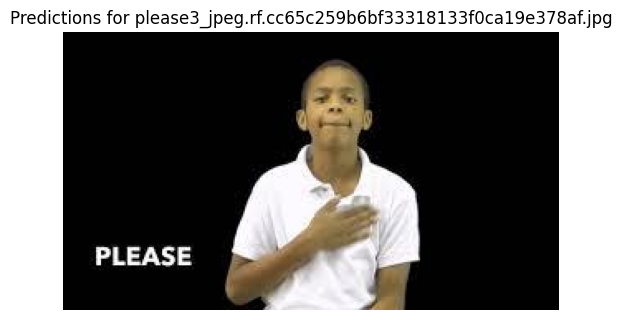


image 1/1 /content/Sign-Language-1/test/images/no7_png.rf.ed67bfa1f08812ed036e006766e490ae.jpg: 576x640 (no detections), 70.6ms
Speed: 4.8ms preprocess, 70.6ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


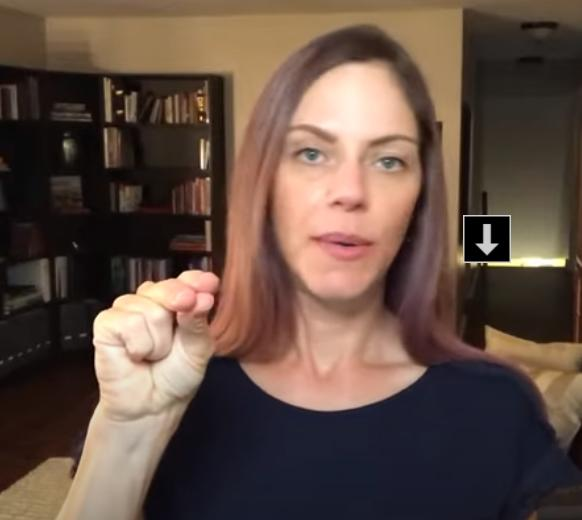

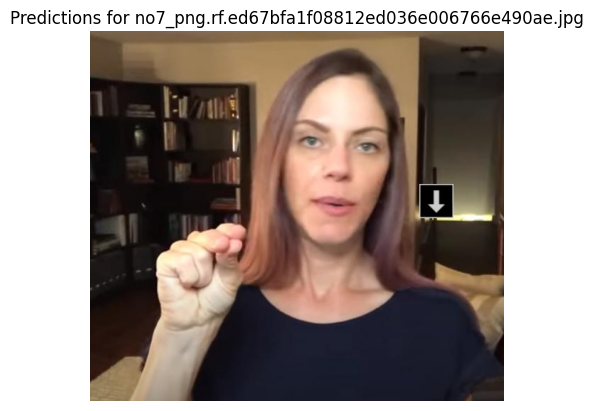


image 1/1 /content/Sign-Language-1/test/images/hello5_png.rf.2211fda286d00bfc38436ce52aaeadfd.jpg: 640x608 1 Hello, 91.2ms
Speed: 3.6ms preprocess, 91.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


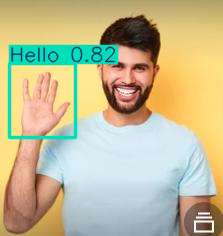

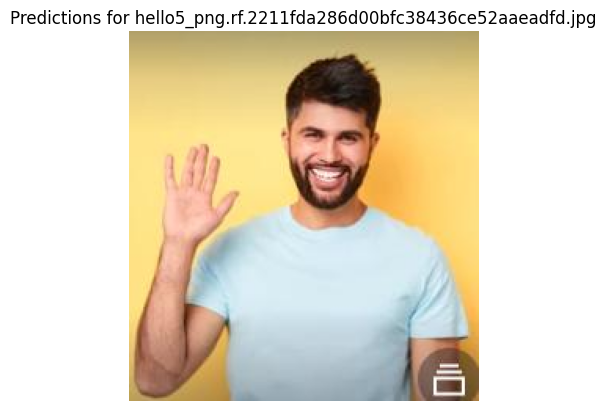


image 1/1 /content/Sign-Language-1/test/images/house5_jpeg.rf.1b9b5a717b98eee6bad0b7e3e35e0963.jpg: 608x640 1 House, 80.3ms
Speed: 3.2ms preprocess, 80.3ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


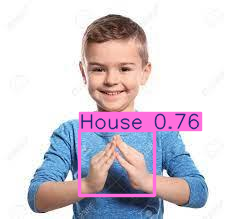

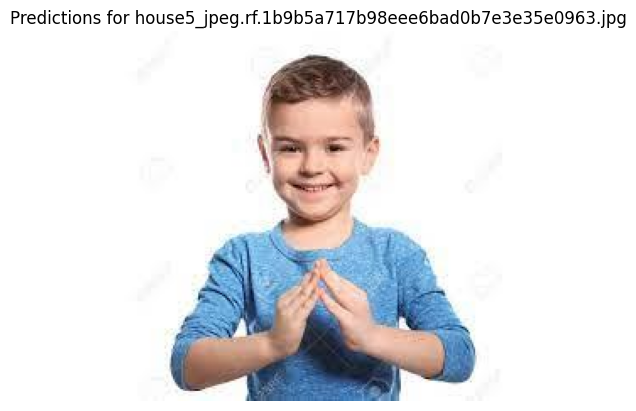

In [ ]:
from ultralytics import YOLO
import os
import cv2
import matplotlib.pyplot as plt

# Load best trained YOLOv11 model weights
model = YOLO("/content/runs/detect/train2/weights/best.pt")  # Update with actual path

# Path to test images folder
test_images_dir = "/content/Sign-Language-1/test/images"  # Update with your test images path

# Get all test image file paths
test_image_files = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if f.endswith('.jpg')]

for img_path in test_image_files:
    # Read image for display
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Run prediction on image file path
    results = model(img_path)

    # Show image with predicted boxes
    results[0].show()

    # Optional: Display with matplotlib inline in Colab or notebook
    plt.imshow(img_rgb)
    plt.title(f"Predictions for {os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()


In [ ]:
from google.colab import files
files.download("/content/runs/detect/train2/weights/best.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


image 1/1 /content/family.jpeg: 384x640 1 Family, 11.1ms
Speed: 1.5ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


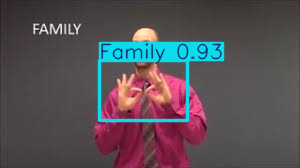

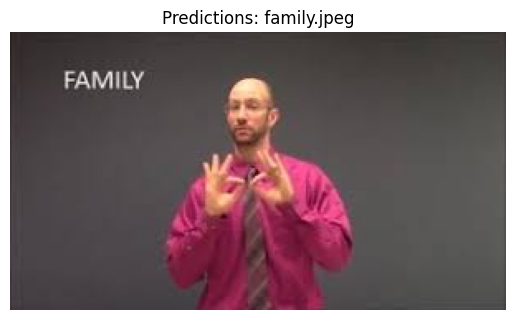

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

# Load your trained model weights
model = YOLO("/content/runs/detect/train2/weights/best.pt")  # Update path if needed

# Path to your test image
img_path = "/content/family.jpeg"

# Run inference
results = model(img_path)

# Display the annotated image
results[0].show()

# Display image with matplotlib inline (optional)
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title("Predictions: family.jpeg")
plt.axis('off')
plt.show()
